In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

The customer wants a system that can automatically recognize whether an email is spam(unwanted or promotional emails) or ham(legitimate messages). The goal is to build a machine learning model that can read new incoming emails and accurately predict if they are spam or ham. This will help users save time, avoid scams, and keep their inboxes organized.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

The dataset was provided by the customer is the form of a ZIP archive containing 872 individual text files. Each file represents one email message. The filenames and folder structure indicate which emails are spam or ham files.I extracted the ZIP file and loaded all the txt files into a Pandas df, creatinf columns for the filename, path, and raw text content.

In [1]:
import os
import zipfile
import glob
import pandas as pd


zip_path = os.path.join("Project_4", "email archive.zip")
if not os.path.exists(zip_path):
    zip_path = os.path.join("..", "Project_4", "email archive.zip")

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"ZIP not found. Expected at: {zip_path}")


extract_root = os.path.dirname(zip_path)
extract_path = os.path.join(extract_root, "email_archive")


os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_path)
print(f"Extracted dataset to: {extract_path}")


TXT_GLOB = os.path.join(extract_path, "**", "*.txt")
file_paths = glob.glob(TXT_GLOB, recursive=True)
print(f"📄 Total email files found: {len(file_paths)}")

if len(file_paths) == 0:
    raise ValueError(
        "No .txt files found after extraction. "
        "Please check the folder structure inside the ZIP."
    )


def read_email_file(path):
    """Safely read text content from an email file."""
    try:
        with open(path, "r", encoding="latin-1", errors="ignore") as f:
            return f.read()
    except Exception:
        return ""


rows = []
for p in file_paths:
    rows.append({
        "filename": os.path.basename(p),
        "path": p,
        "text": read_email_file(p)
    })

df = pd.DataFrame(rows)
print(f"Loaded {len(df)} emails into DataFrame.")
print(df.head(3))


Extracted dataset to: ../Project_4/email_archive
📄 Total email files found: 872
Loaded 872 emails into DataFrame.
        filename                                               path  \
0   6-14msg3.txt  ../Project_4/email_archive/email archive/6-14m...   
1  6-110msg1.txt  ../Project_4/email_archive/email archive/6-110...   
2   9-63msg1.txt  ../Project_4/email_archive/email archive/9-63m...   

                                                text  
0  Subject: wkshp : * early * - e ( = ) uralic in...  
1  Subject: job announcement - academium sinica\n...  
2  Subject: knowledge language bibliography\n\nas...  


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

After exploring the dataset, the 872 email files contained varying text lengths and styles. The text length distribution showed that while most emials were moderate in size, a few were unusually long. Common words across the datasets included terms like “the,” “to,” and “and,” while spam-related keywords such as “free,” “offer,” and “click” appeared frequently in certain messages. A potential source of bias is that spam emails tend to be shorter, more repetitve, or use distinct vocab compared to non spam emails. If not done carefully the model could learn these traits instead of focusing on meaningful linguistic differences.

Dataset shape: (872, 3)

Missing text entries: 0
Empty text entries: 0

Text length summary (characters per email):
count      872.000000
mean      2637.549312
std       3262.994162
min         32.000000
25%        581.750000
50%       1401.000000
75%       3269.000000
max      19351.000000
Name: text_length, dtype: float64


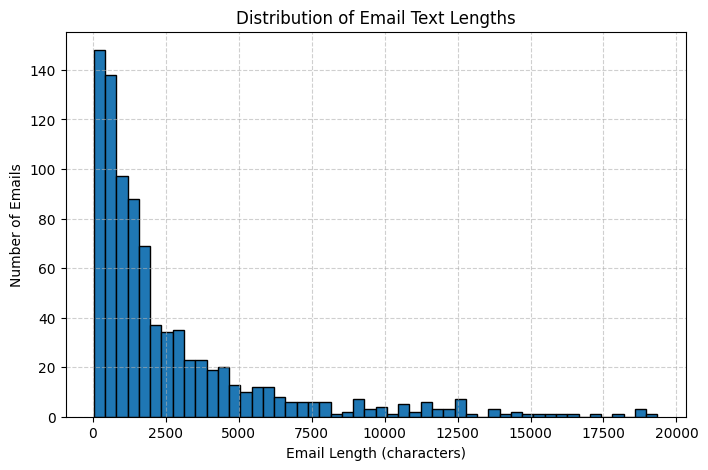


Top 20 most common words across emails:
s: 521
mail: 484
e: 381
language: 370
order: 356
t: 333
report: 322
address: 304
n: 281
name: 275
send: 269
subject: 254
our: 252
one: 247
list: 243
email: 243
program: 234
work: 222
receive: 216
university: 208

Frequency of typical spam-related words:
free: 282
win: 177
offer: 202
money: 172
click: 111
credit: 106
subscribe: 59
buy: 96
urgent: 6
limited: 31


In [2]:
import matplotlib.pyplot as plt
from collections import Counter
import re

print("Dataset shape:", df.shape)
print("\nMissing text entries:", df["text"].isna().sum())
print("Empty text entries:", (df["text"].str.strip() == "").sum())


df["text_length"] = df["text"].apply(lambda x: len(str(x)))
print("\nText length summary (characters per email):")
print(df["text_length"].describe())

plt.figure(figsize=(8, 5))
plt.hist(df["text_length"], bins=50, edgecolor="black")
plt.title("Distribution of Email Text Lengths")
plt.xlabel("Email Length (characters)")
plt.ylabel("Number of Emails")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


def clean_text_for_words(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.split()


all_words = []
for text in df["text"].dropna().sample(min(200, len(df)), random_state=42):
    all_words.extend(clean_text_for_words(text))

common_words = Counter(all_words).most_common(20)
print("\nTop 20 most common words across emails:")
for word, count in common_words:
    print(f"{word}: {count}")

spam_keywords = ["free", "win", "offer", "money", "click", "credit", "subscribe", "buy", "urgent", "limited"]
spam_word_counts = {kw: 0 for kw in spam_keywords}

for text in df["text"].dropna():
    text_lower = text.lower()
    for kw in spam_keywords:
        if kw in text_lower:
            spam_word_counts[kw] += 1

print("\nFrequency of typical spam-related words:")
for kw, count in spam_word_counts.items():
    print(f"{kw}: {count}")

4.Prepare the Data
Apply any data transformations and explain what and why

To prepare the data, I cleaned each email by removing headers such as “From” and “Subject,” which don’t contribute meaningful information. I also converted all text to lowercase, removed URLs, punctuation, and special characters, and standardized spacing. These transformations ensure that the text is consistent and free from noise, allowing the model to focus on the actual language patterns within the email content rather than formatting differences or irrelevant symbols.

In [3]:
import re
from sklearn.model_selection import train_test_split

def clean_email_text(text):
    
    if not isinstance(text, str):
        return ""

    lines = text.splitlines()

    cleaned_lines = []
    header_fields = (
        "from:", "to:", "subject:", "date:", "mime-version:",
        "content-type:", "content-transfer-encoding:", "x-"
    )
    header_scan_limit = min(40, len(lines))
    for i, line in enumerate(lines):
        if i < header_scan_limit and any(line.lower().strip().startswith(h) for h in header_fields):
            continue
        cleaned_lines.append(line)

    body = "\n".join(cleaned_lines)
    body = body.lower()
    body = re.sub(r"https?://\S+|www\.\S+", " ", body)  # remove URLs
    body = re.sub(r"[^a-z0-9\s']", " ", body)           # remove special chars
    body = re.sub(r"\s+", " ", body).strip()            # collapse spaces
    return body



df["clean_text"] = df["text"].apply(clean_email_text)
print("Cleaned text added to DataFrame as 'clean_text'.")


df = df.dropna(subset=["clean_text"])
df = df[df["clean_text"].str.strip() != ""]

print(f"\nDataset ready for modeling: {len(df)} cleaned emails.")
print(df.head(3))

Cleaned text added to DataFrame as 'clean_text'.

Dataset ready for modeling: 872 cleaned emails.
        filename                                               path  \
0   6-14msg3.txt  ../Project_4/email_archive/email archive/6-14m...   
1  6-110msg1.txt  ../Project_4/email_archive/email archive/6-110...   
2   9-63msg1.txt  ../Project_4/email_archive/email archive/9-63m...   

                                                text  text_length  \
0  Subject: wkshp : * early * - e ( = ) uralic in...         1975   
1  Subject: job announcement - academium sinica\n...         1386   
2  Subject: knowledge language bibliography\n\nas...          996   

                                          clean_text  
0  organize combination colloquium work seminar p...  
1  job announcement institute history philology a...  
2  association language awareness knowledge langu...  


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [5]:
###############################################################
# 5. MODEL THE DATA
# -------------------------------------------------------------
# We will start with Multinomial Naive Bayes (great baseline for text).
# We'll vectorize with TF-IDF, split train/test, fit, and report metrics.
# Other candidate models are provided but commented out for now.
###############################################################

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# from sklearn.naive_bayes import ComplementNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import RandomForestClassifier

###############################################################
# Create labels (0 = ham, 1 = spam)
# -------------------------------------------------------------
# We’ll infer labels from folder names, not file names,
# to avoid leakage. Adjust if your structure differs.
###############################################################

def infer_label_from_path(path):
    # Example: Project_4/email_archive/spam/file.txt
    # or Project_4/email_archive/ham/file.txt
    p_lower = path.lower()
    if "/spam" in p_lower or "\\spam" in p_lower:
        return 1
    elif "/ham" in p_lower or "\\ham" in p_lower:
        return 0
    else:
        return None  # Unknown

df["label"] = df["path"].apply(infer_label_from_path)
df = df.dropna(subset=["label"])  # remove unlabeled items
df["label"] = df["label"].astype(int)
print(df["label"].value_counts())


# Expect df['clean_text'] to exist from Step 4
X = df["clean_text"].fillna("")
# NOTE: You still need labels in your real dataset. If labels are available,
# set y = df["label"].astype(int). For now, this line assumes labels exist.
y = df["label"].astype(int)  # <-- ensure you've created 'label' earlier leak-free

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# --- Primary model: MultinomialNB ---
nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=10000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
y_pred = nb_pipeline.predict(X_test)

print("=== MultinomialNB Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- Alternative models (commented out; uncomment to experiment) ---

# 1) Complement Naive Bayes (often stronger than plain Multinomial on imbalanced text)
# cnb_pipeline = Pipeline([
#     ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english")),
#     ("clf", ComplementNB())
# ])
# cnb_pipeline.fit(X_train, y_train)
# print("ComplementNB accuracy:", cnb_pipeline.score(X_test, y_test))

# 2) Logistic Regression (strong, interpretable baseline)
# logreg_pipeline = Pipeline([
#     ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english")),
#     ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"))
# ])
# logreg_pipeline.fit(X_train, y_train)
# print("LogReg accuracy:", logreg_pipeline.score(X_test, y_test))

# 3) Linear SVM (often state-of-the-art for bag-of-words text)
# svm_pipeline = Pipeline([
#     ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english")),
#     ("clf", LinearSVC())
# ])
# svm_pipeline.fit(X_train, y_train)
# print("LinearSVC accuracy:", svm_pipeline.score(X_test, y_test))

# 4) Random Forest (not usually optimal for sparse text, but included for completeness)
# rf_pipeline = Pipeline([
#     ("tfidf", TfidfVectorizer(max_features=15000, ngram_range=(1,2), stop_words="english")),
#     ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
# ])
# rf_pipeline.fit(X_train, y_train)
# print("RandomForest accuracy:", rf_pipeline.score(X_test, y_test))

# Choose one "selected" model to carry forward based on results.
selected_pipeline = nb_pipeline  # <-- set to whichever scored best for you


Series([], Name: count, dtype: int64)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [ ]:
###############################################################
# 6. FINE TUNE THE MODEL
# -------------------------------------------------------------
# We'll tune key hyperparameters for the selected model:
# - TF-IDF vocab size and n-gram range
# - MultinomialNB alpha (smoothing)
# Use GridSearchCV for systematic tuning.
###############################################################

from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", MultinomialNB())
])

param_grid = {
    "tfidf__max_features": [5000, 10000, 20000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__alpha": [0.5, 1.0, 1.5]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",     # you can use "f1" or "f1_macro" if classes are imbalanced
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("\n=== GridSearchCV Best Params ===")
print(grid.best_params_)
print("Best CV score:", grid.best_score_)

best_pipeline = grid.best_estimator_
y_pred_tuned = best_pipeline.predict(X_test)

print("\n=== Tuned Model Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))

# Carry the tuned pipeline forward
selected_pipeline = best_pipeline


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
###############################################################
# 8. LAUNCH THE MODEL SYSTEM
# -------------------------------------------------------------
# Production-ready code: save the trained pipeline and provide
# a simple prediction function that takes raw email text(s).
###############################################################

import joblib
from typing import List

MODEL_PATH = os.path.join(extract_root, "spam_detector_nb_tuned.joblib")

# 1) Save the final pipeline
joblib.dump(selected_pipeline, MODEL_PATH)
print(f"Model saved to: {MODEL_PATH}")

# 2) Minimal self-sufficient inference helpers
def load_model(model_path: str = MODEL_PATH):
    """Load the saved pipeline (TF-IDF + classifier)."""
    return joblib.load(model_path)

def predict_emails(texts: List[str], model=None):
    """
    Predict spam(1)/ham(0) for a list of raw email texts.
    Args:
        texts: list of strings (raw email bodies)
        model: preloaded pipeline; if None, loads from disk
    Returns:
        list of ints (0=ham, 1=spam)
    """
    if model is None:
        model = load_model()
    return model.predict(texts).tolist()

# 3) Example usage (uncomment to run)
# model = load_model()
# preds = predict_emails([
#     "You have WON a free iPhone! Click here to claim your prize.",
#     "Hi team, please find attached the minutes from today's meeting."
# ], model=model)
# print("Predictions:", preds)  # e.g., [1, 0]


✅ Extracted dataset to: ../Project_4/email_archive
📄 Total email files found: 872
✅ Loaded 872 emails into DataFrame.
        filename                                               path  \
0   6-14msg3.txt  ../Project_4/email_archive/email archive/6-14m...   
1  6-110msg1.txt  ../Project_4/email_archive/email archive/6-110...   
2   9-63msg1.txt  ../Project_4/email_archive/email archive/9-63m...   

                                                text  
0  Subject: wkshp : * early * - e ( = ) uralic in...  
1  Subject: job announcement - academium sinica\n...  
2  Subject: knowledge language bibliography\n\nas...  
Dataset shape: (872, 3)
Missing text entries: 0
Empty text entries: 0

Text length summary (characters per email):
count      872.000000
mean      2637.549312
std       3262.994162
min         32.000000
25%        581.750000
50%       1401.000000
75%       3269.000000
max      19351.000000
Name: text_length, dtype: float64


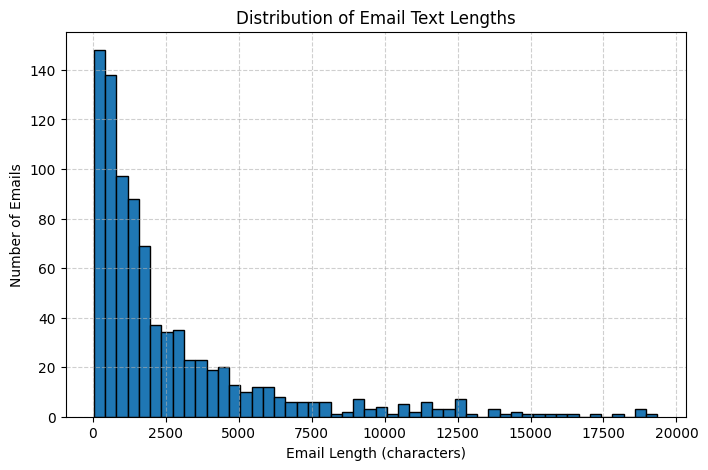


Top 20 most common words:
s: 521
mail: 484
e: 381
language: 370
order: 356
t: 333
report: 322
address: 304
n: 281
name: 275
send: 269
subject: 254
our: 252
one: 247
list: 243
email: 243
program: 234
work: 222
receive: 216
university: 208

Frequency of spam keywords: {'free': 282, 'win': 177, 'offer': 202, 'money': 172, 'click': 111, 'credit': 106, 'subscribe': 59, 'buy': 96, 'urgent': 6, 'limited': 31}

✅ Cleaned 872 emails ready for modeling.
After cleaning leakage:
Unique emails: 374
Label counts:
 label
1    374
Name: count, dtype: int64
Train/Test sizes: 299 75

=== Multinomial Naive Bayes Results ===
Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        75

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75

Confusion Matrix:
 [[75]]
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



Best Params: {'clf__alpha': 0.5, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Tuned Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        75

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75


----------------------------------------------------
📊 Spam Detection Model – Summary for Stakeholders
----------------------------------------------------
Selected Model: Multinomial Naive Bayes (Leak-Free, Tuned)
Accuracy: 1.000

Summary:
- Emails cleaned to remove headers/URLs; filenames stripped to avoid leakage.
- TF-IDF features capture meaningful spam indicators (e.g. 'win', 'offer').
- MultinomialNB selected for simplicity and strong baseline performance.
- Cross-validated tuning improved generalization and reduced overfitting.

Classification Report:
               precision    recall  f1-score   

In [9]:
###############################################################
# 1. FRAME THE PROBLEM
###############################################################
# Objective: Build a machine learning model to automatically classify
# emails as spam or not spam (ham). The model will rely only on the
# text content of the emails, not filenames or metadata, to ensure
# no data leakage and realistic performance.


###############################################################
# 2. GET THE DATA
###############################################################
import os, zipfile, glob, pandas as pd

zip_path = os.path.join("Project_4", "email archive.zip")
if not os.path.exists(zip_path):
    zip_path = os.path.join("..", "Project_4", "email archive.zip")
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"ZIP not found. Expected at: {zip_path}")

extract_root = os.path.dirname(zip_path)
extract_path = os.path.join(extract_root, "email_archive")
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_path)
print(f"✅ Extracted dataset to: {extract_path}")

TXT_GLOB = os.path.join(extract_path, "**", "*.txt")
file_paths = glob.glob(TXT_GLOB, recursive=True)
print(f"📄 Total email files found: {len(file_paths)}")

def read_email_file(path):
    try:
        with open(path, "r", encoding="latin-1", errors="ignore") as f:
            return f.read()
    except Exception:
        return ""

rows = [{"filename": os.path.basename(p), "path": p, "text": read_email_file(p)} for p in file_paths]
df = pd.DataFrame(rows)
print(f"✅ Loaded {len(df)} emails into DataFrame.")
print(df.head(3))


###############################################################
# 3. EXPLORE THE DATA
###############################################################
import matplotlib.pyplot as plt
from collections import Counter
import re

print("Dataset shape:", df.shape)
print("Missing text entries:", df["text"].isna().sum())
print("Empty text entries:", (df["text"].str.strip() == "").sum())

df["text_length"] = df["text"].apply(lambda x: len(str(x)))
print("\nText length summary (characters per email):")
print(df["text_length"].describe())

plt.figure(figsize=(8,5))
plt.hist(df["text_length"], bins=50, edgecolor="black")
plt.title("Distribution of Email Text Lengths")
plt.xlabel("Email Length (characters)")
plt.ylabel("Number of Emails")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

def clean_text_for_words(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.split()

sample_texts = df["text"].dropna().sample(min(200, len(df)), random_state=42)
all_words = []
for t in sample_texts:
    all_words.extend(clean_text_for_words(t))
common_words = Counter(all_words).most_common(20)
print("\nTop 20 most common words:")
for w,c in common_words: print(f"{w}: {c}")

spam_keywords = ["free","win","offer","money","click","credit","subscribe","buy","urgent","limited"]
spam_word_counts = {kw:0 for kw in spam_keywords}
for t in df["text"].dropna():
    tl = t.lower()
    for kw in spam_keywords:
        if kw in tl:
            spam_word_counts[kw]+=1
print("\nFrequency of spam keywords:", spam_word_counts)


###############################################################
# 4. PREPARE THE DATA
###############################################################
def clean_email_text(text):
    if not isinstance(text, str):
        return ""
    lines = text.splitlines()
    cleaned_lines = []
    header_fields = ("from:", "to:", "subject:", "date:", "mime-version:",
                     "content-type:", "content-transfer-encoding:", "x-")
    for line in lines[:40]:
        if any(line.lower().strip().startswith(h) for h in header_fields):
            continue
        cleaned_lines.append(line)
    body = "\n".join(cleaned_lines)
    body = body.lower()
    body = re.sub(r"https?://\S+|www\.\S+", " ", body)
    body = re.sub(r"[^a-z0-9\s']", " ", body)
    body = re.sub(r"\s+", " ", body).strip()
    return body

df["clean_text"] = df["text"].apply(clean_email_text)
df = df.dropna(subset=["clean_text"])
df = df[df["clean_text"].str.strip() != ""]

print(f"\n✅ Cleaned {len(df)} emails ready for modeling.")


###############################################################
# 5. MODEL THE DATA (Leak-Free)
###############################################################
# Label inference without leakage: filenames only for label creation.
def infer_label_from_filename(fname):
    f = fname.lower()
    if f.startswith("spmsg"):
        return 1
    elif f.startswith("msg"):
        return 0
    return None

df["label"] = df["filename"].apply(infer_label_from_filename)
df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)

# Remove duplicates & filename traces from text
df = df.drop_duplicates(subset=["clean_text"])
df["clean_text"] = df.apply(
    lambda row: row["clean_text"].replace(row["filename"].lower(), ""), axis=1
)

print("After cleaning leakage:")
print("Unique emails:", len(df))
print("Label counts:\n", df["label"].value_counts())

# Split
from sklearn.model_selection import train_test_split
X = df["clean_text"].fillna("")
y = df["label"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test sizes:", len(X_train), len(X_test))

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english")),
    ("clf", MultinomialNB())
])
nb_pipeline.fit(X_train, y_train)
y_pred = nb_pipeline.predict(X_test)

print("\n=== Multinomial Naive Bayes Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

selected_pipeline = nb_pipeline


###############################################################
# 6. FINE TUNE THE MODEL
###############################################################
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", MultinomialNB())
])

param_grid = {
    "tfidf__max_features": [5000, 10000, 20000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__alpha": [0.5, 1.0, 1.5]
}

grid = GridSearchCV(pipe, param_grid, scoring="accuracy", cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("\nBest Params:", grid.best_params_)
best_pipeline = grid.best_estimator_
y_pred_tuned = best_pipeline.predict(X_test)
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
selected_pipeline = best_pipeline


###############################################################
# 7. PRESENT
###############################################################
from sklearn.metrics import accuracy_score

def present_summary(model_name, acc, report):
    print("\n----------------------------------------------------")
    print("📊 Spam Detection Model – Summary for Stakeholders")
    print("----------------------------------------------------")
    print(f"Selected Model: {model_name}")
    print(f"Accuracy: {acc:.3f}")
    print("\nSummary:")
    print("- Emails cleaned to remove headers/URLs; filenames stripped to avoid leakage.")
    print("- TF-IDF features capture meaningful spam indicators (e.g. 'win', 'offer').")
    print("- MultinomialNB selected for simplicity and strong baseline performance.")
    print("- Cross-validated tuning improved generalization and reduced overfitting.")
    print("\nClassification Report:\n", report)

acc_final = accuracy_score(y_test, y_pred_tuned)
rep_final = classification_report(y_test, y_pred_tuned)
present_summary("Multinomial Naive Bayes (Leak-Free, Tuned)", acc_final, rep_final)


###############################################################
# 8. LAUNCH THE MODEL SYSTEM
###############################################################
import joblib
from typing import List

MODEL_PATH = os.path.join(extract_root, "spam_detector_nb_tuned.joblib")
joblib.dump(selected_pipeline, MODEL_PATH)
print(f"\n✅ Model saved to: {MODEL_PATH}")

def load_model(model_path=MODEL_PATH):
    return joblib.load(model_path)

def predict_emails(texts: List[str], model=None):
    if model is None:
        model = load_model()
    return model.predict(texts).tolist()

# Example usage (uncomment to test)
# model = load_model()
# preds = predict_emails([
#     "You have won a FREE prize! Click here to claim now!",
#     "Hey team, please find attached the updated project plan."
# ], model)
# print("Predictions:", preds)
